In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, roc_curve, roc_auc_score

# 0. German Credit Dataset

#### 0.1. Helper Function to Import and Preprocess the German Credit Dataset

In [3]:
def get_german_credit_data(file_path="data/GermanDataset.data"):
    """
    Load and format the German Credit dataset
    Returns a DataFrame
    """
    # Read GermanDataset.data file
    dataBase = pd.read_csv('data/GermanDataset.data', sep=" ", header=None, 
                           names=["accountStatus", "creditDuration", "creditHistory", "Purpose", "creditAmount", "Savings", "employmentDuration", 
                                  "installmentRate", "gender&PersonalStatus", "Guarantor", "residenceTime", "Property", "Age", "otherInstallmentPlan", 
                                  "Housing", "numberOfCredit", "Job", "NumberLiablePeople", "Telephone", "foreignWorker", "creditRisk"])
    
    # Encode accountStatus
    dataBase.loc[dataBase["accountStatus"]=="A11", "accountStatus"] = 1
    dataBase.loc[dataBase["accountStatus"]=="A12", "accountStatus"] = 1
    dataBase.loc[dataBase["accountStatus"]=="A13", "accountStatus"] = 1
    dataBase.loc[dataBase["accountStatus"]=="A14", "accountStatus"] = 0

    # Qualitative features to dummies
    dataBase["creditRisk"] = dataBase["creditRisk"].replace(2, 0)
    copyDataBase = dataBase.copy()
    for colName in dataBase.columns:
        if dataBase[colName].dtypes == "object":
            dataBase = pd.get_dummies(dataBase, columns=[colName])
    
    # Remove "accountStatus_0", "foreignWorker_A202", and "Telephone_A192" 
    # They don't bring new information
    dataBase = dataBase.drop(["accountStatus_0", "foreignWorker_A202", "Telephone_A192"], axis=1)

    # Re-encode gender&PersonalStatus feature
    dataBaseGender = dataBase.copy()
    dataFrameGender = pd.DataFrame(copyDataBase["gender&PersonalStatus"])
    dataBaseGender = pd.concat([dataBaseGender,dataFrameGender],axis=1)
    dataBaseGender.drop(["gender&PersonalStatus_A91", "gender&PersonalStatus_A92", "gender&PersonalStatus_A93", "gender&PersonalStatus_A94"], 
                        axis=1, inplace=True)
    male = ["A91","A93","A94"]
    female = ["A92","A95"]
    for modalites in male:
        dataBaseGender["gender&PersonalStatus"] = dataBaseGender["gender&PersonalStatus"].replace(modalites,"0")
    for modalites in female:
        dataBaseGender["gender&PersonalStatus"] = dataBaseGender["gender&PersonalStatus"].replace(modalites,"1")
    dataBaseGender.rename(columns={"gender&PersonalStatus":"gender", "Telephone_A191":"Telephone"},inplace=True)

    # Return the preprocessed DataFrame
    return dataBaseGender

In [4]:
germanCreditData = get_german_credit_data()

#### 0.2. Quick Exploration of the Dataset

In [5]:
germanCreditData.shape

(1000, 54)

In [6]:
germanCreditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   creditDuration             1000 non-null   int64 
 1   creditAmount               1000 non-null   int64 
 2   installmentRate            1000 non-null   int64 
 3   residenceTime              1000 non-null   int64 
 4   Age                        1000 non-null   int64 
 5   numberOfCredit             1000 non-null   int64 
 6   NumberLiablePeople         1000 non-null   int64 
 7   creditRisk                 1000 non-null   int64 
 8   accountStatus_1            1000 non-null   uint8 
 9   creditHistory_A30          1000 non-null   uint8 
 10  creditHistory_A31          1000 non-null   uint8 
 11  creditHistory_A32          1000 non-null   uint8 
 12  creditHistory_A33          1000 non-null   uint8 
 13  creditHistory_A34          1000 non-null   uint8 
 14  Purpose_A

#### 0.3. Get the Features (x) and the Target (y)

In [7]:
x = germanCreditData.drop(["creditRisk"], axis=1)
y = germanCreditData["creditRisk"]

In [8]:
print(x.shape)
print(y.shape)

(1000, 53)
(1000,)


# 1. Decision Tree Classifier

#### 1.1. Fit the Model

In [9]:
model_fit = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy', 
                                   max_depth=8, max_features='auto', max_leaf_nodes=None, 
                                   min_impurity_decrease=0.0, min_impurity_split=None, 
                                   min_samples_leaf=9, min_samples_split=9,
                                   min_weight_fraction_leaf=0.0, 
                                   # presort='deprecated',
                                   random_state=42, splitter='best').fit(x, y)

#### 1.2. Make Predictions

In [10]:
predictions = model_fit.predict(x)
predictionTree = predictions.copy()

In [11]:
proba_Tree = []

for probs in model_fit.predict_proba(x):
    proba_Tree.append(probs[1])
    
proba_Tree = pd.DataFrame([proba_Tree]).transpose()
proba_Tree.columns= ["S"]

#### 1.3. Compute Accuracy & AUC

In [12]:
confusion_matrix(y,predictionTree)

sumDiagonal=0
for j in range(0,2):
    sumDiagonal += confusion_matrix(y,predictionTree)[j][j]

accuracy = round( (sumDiagonal / proba_Tree.shape[0])*100,2)
print("Accuracy Rate:", accuracy, "%")

Accuracy Rate: 75.7 %


In [13]:
AUCTree = roc_auc_score(y,proba_Tree)
print("AUC :", round(AUCTree, 4))

AUC : 0.8032


#### 1.4. Feature Sorted by Importance

In [14]:
features_importance = zip(x.columns, model_fit.feature_importances_)
features_importance = sorted(features_importance, key = lambda x: x[1], reverse=True)

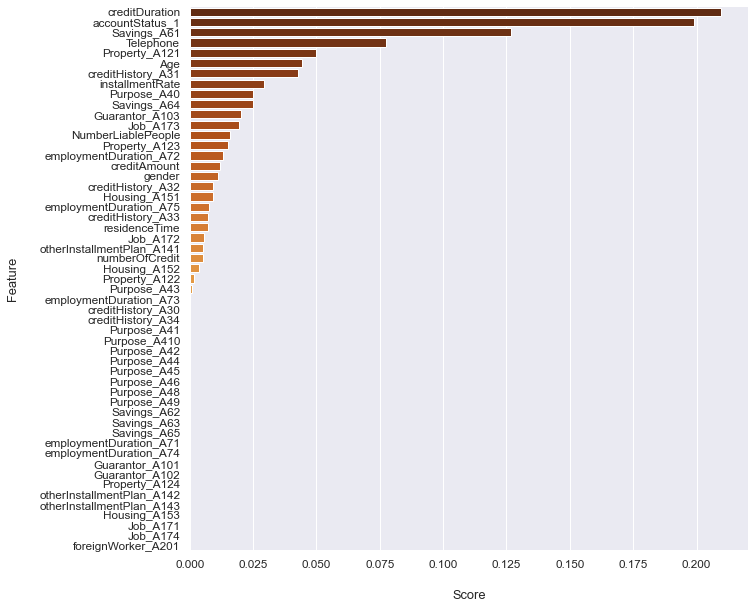

In [15]:
features, importance_score = zip(*features_importance)
feature_importance = pd.DataFrame({"Feature": features, "Score": importance_score})
# feature_importance = feature_importance[feature_importance["Score"] > 0.]
plt.rcParams['figure.figsize'] = [10, 10]
sns.set_theme()
sns.set_context("notebook", font_scale=1.07)
sns.barplot(y="Feature", x="Score", data=feature_importance, palette="YlOrBr_r")
sns.despine(left=True, bottom=True)
plt.xlabel("Score", labelpad=20)
plt.ylabel("Feature", labelpad=20)
plt.show()

In [16]:
for feature, score in features_importance:
    print(f"Feature: {feature:<30} Score: {score:.5f}")

Feature: creditDuration                 Score: 0.20970
Feature: accountStatus_1                Score: 0.19910
Feature: Savings_A61                    Score: 0.12665
Feature: Telephone                      Score: 0.07766
Feature: Property_A121                  Score: 0.05002
Feature: Age                            Score: 0.04447
Feature: creditHistory_A31              Score: 0.04265
Feature: installmentRate                Score: 0.02927
Feature: Purpose_A40                    Score: 0.02511
Feature: Savings_A64                    Score: 0.02497
Feature: Guarantor_A103                 Score: 0.02014
Feature: Job_A173                       Score: 0.01943
Feature: NumberLiablePeople             Score: 0.01608
Feature: Property_A123                  Score: 0.01529
Feature: employmentDuration_A72         Score: 0.01327
Feature: creditAmount                   Score: 0.01203
Feature: gender                         Score: 0.01121
Feature: creditHistory_A32              Score: 0.00913
Feature: H

# 2. Some Helper Functions

#### 2.1. Test if feature exists and infer its type

In [17]:
def _infer_feature_type(feature, X):
    """Test if feature exists and infer its type
    
    Parameters
    ----------
    feature: string or list
        string: for numeric (e.g. 'Age') and binary (e.g. 'accountStatus_1') feature 
        list: for one-hot encoded feature (e.g. creditHistory is represented as: ['creditHistory_A30', 'creditHistory_A31', 'creditHistory_A32', 'creditHistory_A33', 'creditHistory_A34'])
    X: DataFrame
    
    Returns
    -------
    Feature types:
        1. binary
        2. onehot
        3. numeric
    """
    if type(feature) == list:
        if len(feature) < 2: 
            raise ValueError('one-hot encoded feature should contain at least 2 elements')
        # one-hot encoded feature (represented as list) should be a subset of the features set
        if not (set(feature) < set(X.columns.values)):
            raise ValueError(f"feature does not exist: {feature}")
        feature_type = 'onehot'
    else:
        if feature not in X.columns.values:
            raise ValueError(f"feature does not exist: {feature}")
        sorted_values = sorted(list(np.unique(X[feature])))
        if sorted_values == [0, 1] or sorted_values == ["0", "1"]:
            feature_type = 'binary'
        else:
            feature_type = 'numeric'
    return feature_type

#### 2.2. Generic Plotting Function for PDP and ALE

In [18]:
def generic_pretty_plot(grid, values, reference_feature, feature_type, fig_size=[10, 5]):
    """Generic Plotting Function for PDP and ALE
    
    Parameters
    ----------
    grid: x-axis values
    values: y-axis values
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    feature_type: numeric, binary, or one-hot
    fig_size: 2-element list
    
    Returns
    -------
    tuple: reference to matplotlib plot, reference_feature
    """
    # pretty feature name
    # remove "_" if binary or one-hot
    if feature_type == "onehot": reference_feature = reference_feature[0].split("_")[0]
    elif feature_type == "binary": reference_feature = reference_feature.split("_")[0]
    # set figure size
    plt.rcParams['figure.figsize'] = fig_size 
    # plotting
    pdp_df = pd.DataFrame({"feature": grid, "pdp": values})
    sns.set_theme()
    sns.set_context("notebook", font_scale=1.2)
    ax = sns.lineplot(x="feature", y="pdp", data=pdp_df)
    plt.xlabel(reference_feature, labelpad=10)
    return ax, reference_feature

# 3. Partial Dependence Plot (PDP)

#### 3.1. Compute PD Values

In [19]:
def pdp(estimator, X, reference_feature, grid_resolution=50):
    """Compute Partial Dependence
    
    Parameters
    ----------
    estimator: A fitted estimator object implementing `predict_proba`
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    grid_resolution: int, default=50
        The number of equally spaced points on the x-axis of the plot
    
    Returns
    -------
    tuple : grid values, pdp values, feature_type
    """
    # Check if the feature exist and infer its type: numeric, binary, or one-hot encoded
    feature_type = _infer_feature_type(reference_feature, X)
    pdp_average_prediction_prob = []
    if feature_type == "numeric":
        # compute the min and max in order to generate the grid (i.e. x-axis values)
        rf_min = X[reference_feature].min()
        rf_max = X[reference_feature].max()
        grid = np.linspace(rf_min, rf_max, num=grid_resolution, endpoint=True)
        for i in grid:
            pdp_df = X.copy()
            # set the feature to a fixed value
            pdp_df[reference_feature] = i
            # compute the average predicted probability
            pdp_predictions = estimator.predict_proba(pdp_df)[:, 1]
            pdp_average_prediction_prob.append(pdp_predictions.mean())
    elif feature_type == "onehot":
        grid = reference_feature
        for main_label in grid:
            pdp_df = X.copy()
            # get the other modalities of the feature
            other_labels = set(grid) -  set([main_label]) 
            # For one-hot encoded feature, each modality of the categorical feature is represented a vector
            # as a consequence, setting the feature to a fixed modality, say "A30" for "creditHistory" is equivalent to set "creditHistory_A30" to 1
            # and all other to 0, i.e. creditHistory_A31, creditHistory_A32...
            pdp_df[main_label] = 1
            pdp_df[list(other_labels)] = 0
            # compute the average predicted probability
            pdp_predictions = estimator.predict_proba(pdp_df)[:, 1]
            pdp_average_prediction_prob.append(pdp_predictions.mean())
    else:
        # feature_type == "binary"
        grid = [0, 1]
        for i in grid:
            pdp_df = X.copy()
            # set the feature to a fixed value (either 0 or 1)
            pdp_df[reference_feature] = i
            # compute the average predicted probability
            pdp_predictions = estimator.predict_proba(pdp_df)[:, 1]
            pdp_average_prediction_prob.append(pdp_predictions.mean())
        # convert to string for pretty plotting
        grid = [str(x) for x in grid]
    return grid, pdp_average_prediction_prob, feature_type

#### 3.2. PD Plot

In [20]:
def pdp_pretty_plot(grid, values, reference_feature, feature_type, fig_size=[10, 5]):
    """Generate Partial Dependence Plot
    
    Parameters
    ----------
    grid: x-axis values
    values: y-axis values
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    feature_type: numeric, binary, or one-hot
    fig_size: 2-element list
    
    Returns
    -------
    plot figure
    """
    ax, reference_feature = generic_pretty_plot(grid, values, reference_feature, feature_type, fig_size)
    ax.set_ylabel("Average Predicted Probability", labelpad=20)
    ax.set_title('PD Plot for Feature:\n' + reference_feature)

#### 3.3. Example 1: Numerical Feature

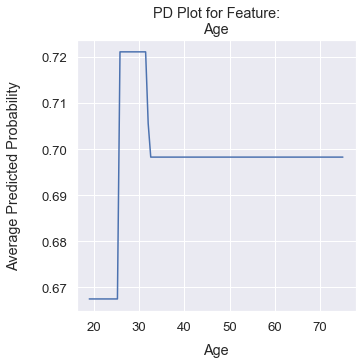

In [21]:
reference_feature = "Age"
grid, pdp_values, feature_type = pdp(model_fit, x, reference_feature, grid_resolution=100)
pdp_pretty_plot(grid, pdp_values, reference_feature, feature_type, fig_size=[5, 5])

Our results match sklearn results:

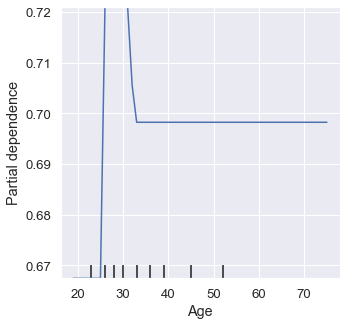

In [22]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(model_fit, x, features=(4,))

#### 3.4. Example 2: Binary Feature

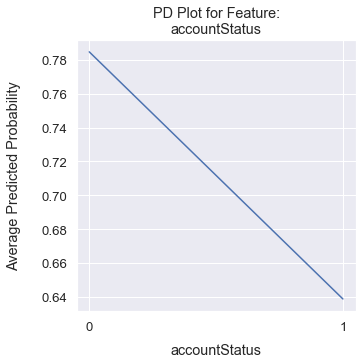

In [23]:
reference_feature = "accountStatus_1"
grid, pdp_values, feature_type = pdp(model_fit, x, reference_feature)
pdp_pretty_plot(grid, pdp_values, reference_feature, feature_type, fig_size=[5, 5])

Our results match sklearn results:

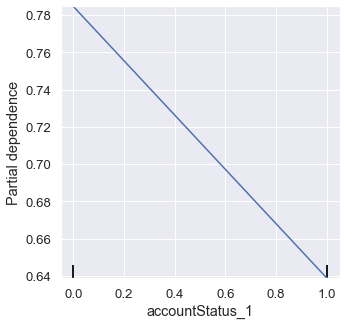

In [24]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(model_fit, x, features=(7,))

#### 3.5. Example 3: One-Hot Encoded Feature

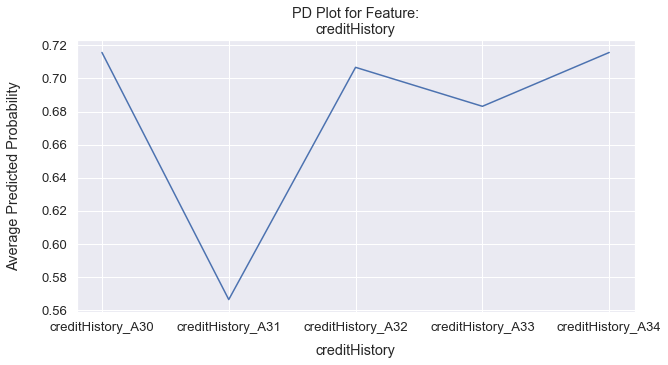

In [25]:
reference_feature = [s for s in x.columns if s.startswith('creditHistory')]
grid, pdp_values, feature_type = pdp(model_fit, x, reference_feature)
pdp_pretty_plot(grid, pdp_values, reference_feature, feature_type)

# 4. Individual Conditional Expectation

#### 4.1. Compute ICE Values

In [26]:
def ice(estimator, X, reference_feature, grid_resolution=50):
    """Compute Individual Conditional Expectation
    
    Parameters
    ----------
    estimator: A fitted estimator object implementing `predict_proba`
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    grid_resolution: int, default=50
        The number of equally spaced points on the x-axis of the plot. 
        Used only if the reference feature is numeric
    
    Returns
    -------
    tuple : grid, ice values of shape (nrows, grid_resolution), feature_type
    """
    # NB: Same reasoning as PDP
    # Except we do not return the average predicted probability
    # Instead, we return individual predictions, shape: (number of observations, grid_resolution) 
    feature_type = _infer_feature_type(reference_feature, X)
    ice_prediction_prob = []
    if feature_type == "numeric":
        # compute the min and max in order to generate the grid (i.e. x-axis values)
        rf_min = X[reference_feature].min()
        rf_max = X[reference_feature].max()
        grid = np.linspace(rf_min, rf_max, num=grid_resolution, endpoint=True)
        for i in grid:
            ice_df = X.copy()
            # set the feature to a fixed value
            ice_df[reference_feature] = i
            # compute individual predictions
            ice_predictions = estimator.predict_proba(ice_df)[:, 1]
            ice_prediction_prob.append(ice_predictions)
        ice_prediction_prob = np.stack(ice_prediction_prob).T # shape: (number of observations, grid_resolution)  
    elif feature_type == "onehot":
        grid = reference_feature
        for main_label in grid:
            ice_df = X.copy()
            # get the other modalities of the feature
            other_labels = set(reference_feature) -  set([main_label]) 
            # For one-hot encoded feature, each modality of the categorical feature is represented a vector
            # as a consequence, setting the feature to a fixed modality, say "A30" for "creditHistory" is equivalent to set "creditHistory_A30" to 1
            # and all other to 0, i.e. creditHistory_A31, creditHistory_A32...
            ice_df[main_label] = 1
            ice_df[list(other_labels)] = 0
            # compute individual predictions
            ice_predictions = estimator.predict_proba(ice_df)[:, 1]
            ice_prediction_prob.append(ice_predictions)
        ice_prediction_prob = np.stack(ice_prediction_prob).T
    else:
        # feature_type == "binary"
        grid = [0, 1]
        for i in grid:
            ice_df = X.copy()
            # set the feature to a fixed value (either 0 or 1)
            ice_df[reference_feature] = i
            # compute individual predictions
            ice_predictions = estimator.predict_proba(ice_df)[:, 1]
            ice_prediction_prob.append(ice_predictions)
        ice_prediction_prob = np.stack(ice_prediction_prob).T
        # convert to string for pretty plotting
        grid = [str(x) for x in grid]
    return grid, ice_prediction_prob, feature_type

#### 4.2. ICE Plot

In [27]:
def ice_pretty_plot(grid, values, reference_feature, feature_type, fig_size=[10, 5]):
    """Generate Individual Conditional Expectation Plot
    
    Parameters
    ----------
    grid: x-axis values
    values: y-axis values
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    feature_type: numeric, binary, or one-hot
    fig_size: 2-element list
    
    Returns
    -------
    plot figure
    """
    # pretty feature name
    if feature_type == "onehot": reference_feature = reference_feature[0].split("_")[0]
    elif feature_type == "binary": reference_feature = reference_feature.split("_")[0]
    # set figure size
    plt.rcParams['figure.figsize'] = fig_size 
    # plotting
    sns.set_theme()
    sns.set_context("notebook", font_scale=1.2)
    # Plot one line per observation
    for i in range(values.shape[0]):
        plt.plot(grid, values[i,], color="C0", linewidth=0.5)
    # plot the average in red (i.e. pdp)
    pdp = np.mean(values, axis=0)
    plt.plot(grid, pdp, color="red")
    plt.title('ICE Plot for Feature:\n' + reference_feature)
    plt.xlabel(reference_feature, labelpad=10)
    plt.ylabel("Predicted Probability", labelpad=20)
    # add custom legend
    custom_line = Line2D([0], [0], color="red", lw=1)
    plt.legend([custom_line], ['Average'], shadow=True, loc="upper left", bbox_to_anchor=(1, 1))

#### 4.3. Example 1: Numerical Feature

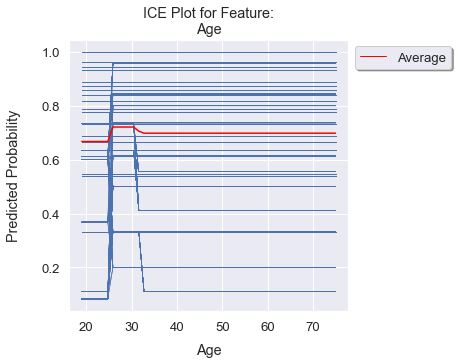

In [28]:
reference_feature = "Age"
grid, ice_values, feature_type = ice(model_fit, x, reference_feature, grid_resolution=50)
ice_pretty_plot(grid, ice_values, reference_feature, feature_type, fig_size=[5, 5])

Our results match sklearn results:

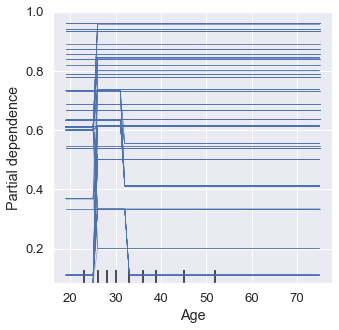

In [29]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams['figure.figsize'] = [5, 5]
plot_partial_dependence(model_fit, x, features=(4,), kind="individual", subsample=None)

#### 4.4. Example 2: Binary Feature

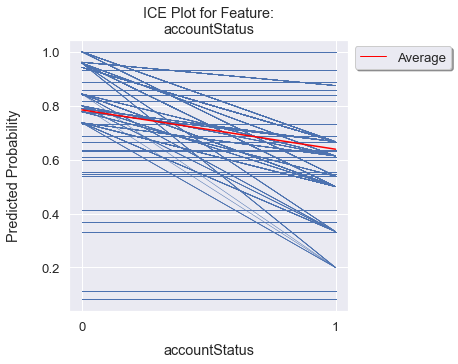

In [30]:
reference_feature = "accountStatus_1"
grid, ice_values, feature_type = ice(model_fit, x, reference_feature)
ice_pretty_plot(grid, ice_values, reference_feature, feature_type, fig_size=[5, 5])

Our results match sklearn results:

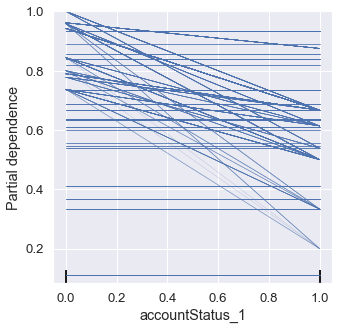

In [31]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams['figure.figsize'] = [5, 5]
plot_partial_dependence(model_fit, x, features=(7,), kind="individual", subsample=None)

#### 4.5. Example 3: One-Hot Encoded Feature

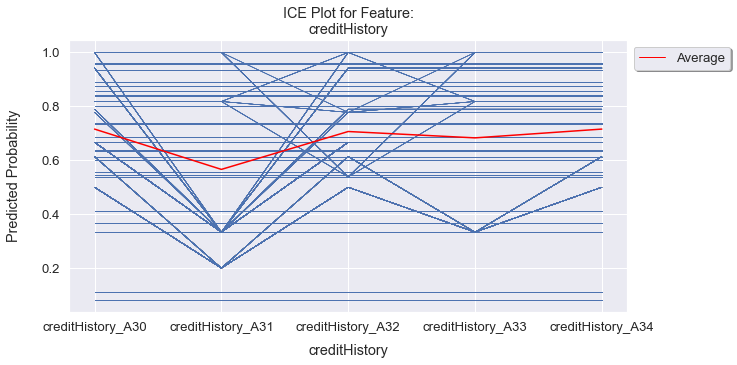

In [32]:
reference_feature = [s for s in x.columns if s.startswith('creditHistory')]
grid, ice_values, feature_type = ice(model_fit, x, reference_feature)
ice_pretty_plot(grid, ice_values, reference_feature, feature_type, fig_size=[10, 5])

# 5. Accumulated Local Effects

#### 5.1 Compute ALE Values 

In [33]:
def ale(estimator, X, reference_feature, bins=10):
    """Compute Accumulated Local Effects
    
    Parameters
    ----------
    estimator: A fitted estimator object implementing `predict_proba`
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    bins: int, default=10
        The number of quantiles is calculated as (bins + 1). 
        Used only if the reference feature is numeric
    
    Returns
    -------
    tuple : quantiles, ale, feature_type
    """
    # Check if the feature exist and infer its type: numeric, binary, or one-hot encoded
    feature_type = _infer_feature_type(reference_feature, X)
    if feature_type == "numeric":
        # Compute the quantiles (x-axis)
        # We use np.unique because np.quantile may return repeated values (depending on the distribution shape of the reference feature)
        quantiles = np.unique(np.quantile(X[reference_feature], q = np.linspace(0, 1, bins + 1), interpolation="lower"))
        # Re-compute the number of bins in order to reflect the computed quantiles
        bins = len(quantiles) - 1
        # Assign observations to quantile intervals
        # We substract 1 to start counting from 0
        # np.clip ensure that the observation with the min value of the feature to be assigned to interval 0 and not -1
        indices = np.clip(np.digitize(X[reference_feature], quantiles, right=True) - 1, 0, None)
        # Initialize empty vector to store ALE values
        ale = np.zeros(bins)
        # We also need to keep track of the number of observations assigned to each bin in order to compute weighted averages
        bins_sample_size = np.zeros(bins)
        # For each bin [q_lower, q_upper]:
        #    - Step 1: subset observations assigned to this bin
        #    - Step 2: For those observations, replace the feature by q_upper (X1) and then again by q_lower (X0)
        #    - Step 3: Compute the individual effects as the difference in predicted probabilities between X1 and X0 (individual_effects)
        #    - Step 4: Compute the average effect for that bin, i.e. individual_effects.mean()
        for i in range(bins):
            x_subset = X[indices == i]
            subset_size = x_subset.shape[0]
            if (subset_size > 0):
                x_upper = x_subset.copy()
                x_lower = x_subset.copy()
                x_upper[reference_feature] = quantiles[i + 1]
                x_lower[reference_feature] = quantiles[i]
                individual_effect = estimator.predict_proba(x_upper)[:, 1] - estimator.predict_proba(x_lower)[:, 1] 
                ale[i] = individual_effect.mean()
                bins_sample_size[i] = subset_size
        # Compute the Accumulated effect (i.e. cumulative sum of the average effects)
        ale = np.array([0, *ale.cumsum()])
        # We use the center of quantiles intervals for plotting
        quantiles = (quantiles[1:] + quantiles[:-1]) / 2
        ale = (ale[1:] + ale[:-1]) / 2
        # Compute the centered ALE
        ale -= np.sum(ale * bins_sample_size) / X.shape[0]
    elif feature_type == "onehot":
        # compute the number of modalities
        num_cat = len(reference_feature)
        # Initialize empty vector to store ALE values
        ale = np.zeros(num_cat)
        # We also need to keep track of the number of observations assigned to each bin in order to compute weighted averages
        sample_size = np.zeros(num_cat)
        # Assume that modalities are ordered by their similarity to each other, then:
        # For each modality (i.e. bin in x-axis):
        #    - Step 1: subset observations assigned to this modality (i.e. == 1): X1
        #    - Step 2: For those observations, replace the modality by 0 (i.e. as not having this modality) and set the similar modality to 1 (i.e. as having the modality): X0
        #    - Step 3: Compute the individual effects as the difference in predicted probabilities between X1 and X0 (individual_effects)
        #    - Step 4: Compute the average effect for that bin, i.e. individual_effects.mean()
        for i in range(num_cat):
            main_feature = reference_feature[i]
            neighbor_feature = reference_feature[i - 1]
            x_subset = X[X[main_feature] == 1]
            subset_size = x_subset.shape[0]
            if (subset_size > 0):
                x_lower = x_subset.copy()
                x_lower[main_feature] = 0
                x_lower[neighbor_feature] = 1
                individual_effect = estimator.predict_proba(x_subset)[:, 1] - estimator.predict_proba(x_lower)[:, 1] 
                ale[i] = individual_effect.mean()
                sample_size[i] = subset_size
        # Compute the Accumulated effect (i.e. cumulative sum of the average effects)
        ale = ale.cumsum()
        # Compute the centered ALE
        ale -= np.sum(ale * sample_size) / X.shape[0]
        quantiles = reference_feature
    else:
        # feature_type == "binary":
        # We follow the same logic as "onehot" case
        # The only difference is that we have only two modalities, 0 and 1
        ale = np.zeros(2)
        sample_size = np.zeros(2)
        for i in range(2):
            x_subset = X[X[reference_feature] == i]
            subset_size = x_subset.shape[0]
            if (subset_size > 0):
                x_neighbor = x_subset.copy()
                x_neighbor[reference_feature] = (1 - i)
                individual_effect = estimator.predict_proba(x_subset)[:, 1] - estimator.predict_proba(x_neighbor)[:, 1] 
                ale[i] = individual_effect.mean()
                sample_size[i] = subset_size
        ale = ale.cumsum()
        ale -= np.sum(ale * sample_size) / X.shape[0]
        quantiles = ["0", "1"]
    return quantiles, ale, feature_type

#### 5.2. ALE Plot

In [34]:
def ale_pretty_plot(grid, values, reference_feature, feature_type, fig_size=[10, 5]):
    """Generate Accumulated Local Effects Plot
    
    Parameters
    ----------
    grid: x-axis values
    values: y-axis values
    reference_feature: string or list
        Which feature is calculated on, list for one-hot encoded feature
    feature_type: numeric, binary, or one-hot
    fig_size: 2-element list
    
    Returns
    -------
    plot figure
    """
    ax, reference_feature = generic_pretty_plot(grid, values, reference_feature, feature_type, fig_size)
    ax.set_ylabel("ALE", labelpad=20)
    ax.set_title('ALE Plot for Feature:\n' + reference_feature)

#### 5.3. Example 1: Numerical Feature

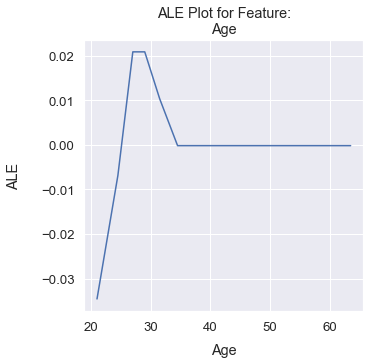

In [35]:
reference_feature = "Age"
grid, ale_values, feature_type = ale(model_fit, x, reference_feature)
ale_pretty_plot(grid, ale_values, reference_feature, feature_type, fig_size=[5,5])

Our results match alepython results:

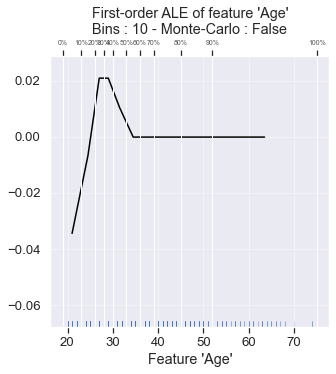

<AxesSubplot:title={'center':"First-order ALE of feature 'Age'\nBins : 10 - Monte-Carlo : False"}, xlabel="Feature 'Age'">

In [36]:
from alepython import ale_plot

model_fit.predict = lambda x: model_fit.predict_proba(x)[:,1]
ale_plot(model_fit, train_set = x, features = 'Age', bins=10)

#### 5.4. Example 2: Binary Feature

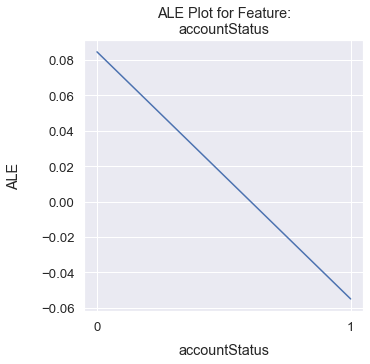

In [37]:
reference_feature = "accountStatus_1"
grid, ale_values, feature_type = ale(model_fit, x, reference_feature)
ale_pretty_plot(grid, ale_values, reference_feature, feature_type, fig_size=[5,5])

#### 5.5. Example 3: One-Hot Encoded Feature

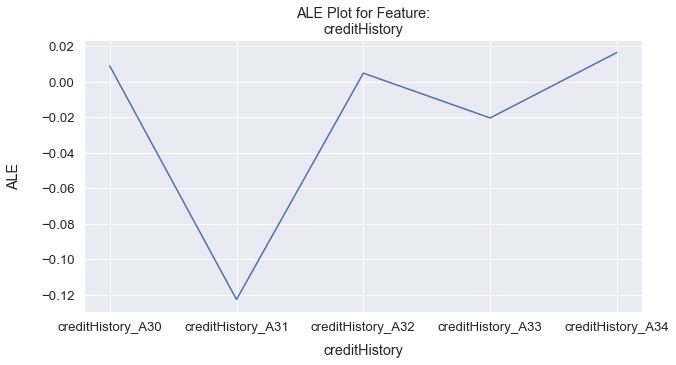

In [39]:
reference_feature = [s for s in x.columns if s.startswith('creditHistory')]
grid, ale_values, feature_type = ale(model_fit, x, reference_feature)
ale_pretty_plot(grid, ale_values, reference_feature, feature_type)